# Importance Sampling

In [147]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.stats import norm, t

## Data Construction and Estimation of Nominal Return Parameters

### Objective
The purpose of this step is to construct a time series of daily market returns for the Nasdaq-100 proxy ETF (QQQ) and to estimate the parameters of a nominal return distribution. These parameters serve as the baseline inputs for all subsequent Monte Carlo, discrete moment matching (DMM), and importance sampling (IS) procedures.



### Market Data and Return Definition
Let $S_t$ denote the adjusted closing price of QQQ on trading day $t$. Daily log-returns are defined as

$$
R_t = \log\!\left(\frac{S_t}{S_{t-1}}\right), \qquad t = 1, \dots, T.
$$

The sample period spans from January 1, 2023 to January 1, 2025. Observations corresponding to missing values induced by the lagged return calculation are removed, resulting in a sample of $T$ daily returns $\{R_t\}_{t=1}^T$.



### Loss Definition
Throughout the study, risk is measured over a one-day horizon. We define the loss random variable as

$$
L = -R,
$$

so that negative returns correspond to positive losses. Value-at-Risk (VaR) and Expected Shortfall (ES) are therefore expressed in terms of the upper tail of the loss distribution.


### Estimation of Nominal Gaussian Parameters
To obtain a benchmark parametric model for returns, we assume that daily returns follow a Gaussian distribution under a nominal probability measure,

$$
R \sim \mathcal{N}(\mu, \sigma^2).
$$

The parameters $(\mu, \sigma)$ are estimated from the historical return sample using maximum-likelihood estimators:

$$
\hat{\mu} = \frac{1}{T}\sum_{t=1}^T R_t,
$$

$$
\hat{\sigma} = \sqrt{\frac{1}{T}\sum_{t=1}^T (R_t - \hat{\mu})^2}.
$$

These estimates summarize the empirical first and second moments of market returns and define the nominal return model used in subsequent simulation-based VaR estimation.



### Role in the Overall Framework
The estimated parameters $(\hat{\mu}, \hat{\sigma})$ serve two distinct roles in the analysis:

1. They define the assumed return distribution used by the Gaussian Monte Carlo and importance sampling VaR estimators.
2. They provide a realistic scale for the simulation experiments, even when the true data-generating process is later taken to be heavy-tailed (e.g., Student-$t$).

This separation between the assumed model and the true data-generating process allows us to explicitly study the impact of tail misspecification on VaR estimation accuracy.


In [150]:
ticker = "QQQ"
start_date = "2023-01-01"
end_date = "2025-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
data["Return"] = np.log(data["Close"] / data["Close"].shift(1))
data = data.dropna()
returns = data["Return"].to_numpy()

mu_hat = returns.mean()
sigma_hat = returns.std(ddof=0)

print(f"QQQ sample size: {len(returns)}")
print(f"mu_hat={mu_hat:.6f}, sigma_hat={sigma_hat:.6f}\n")

/var/folders/2b/5yl7knkn4sz3d6glkhc8tcym0000gn/T/ipykernel_26359/2834470885.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

QQQ sample size: 501
mu_hat=0.001341, sigma_hat=0.011287



### Empirical Summary of Estimated Parameters

Applying the procedure above to QQQ daily returns over the sample period yields a total of

$$
T = 501
$$

daily observations. The estimated parameters of the nominal Gaussian return model are

$$
\hat{\mu} = 0.001341,
\qquad
\hat{\sigma} = 0.011287.
$$

The estimate $\hat{\mu}$ corresponds to an average daily log-return of approximately $0.13\%$, while $\hat{\sigma}$ implies a daily volatility of approximately $1.13\%$. These magnitudes are consistent with historical behavior of a diversified equity index and confirm that the sample period provides a realistic scale for market risk.



### Interpretation and Use in Subsequent Analysis
The parameter $\hat{\sigma}$ primarily determines the scale of tail losses and therefore plays a central role in Value-at-Risk estimation. The estimated mean $\hat{\mu}$ is small relative to volatility and has only a minor effect on extreme quantiles, but it is retained for completeness and consistency with the assumed return model.

Importantly, these estimates are treated as the parameters of the \emph{assumed} return distribution in the simulation-based VaR engines. In later sections, returns are generated from heavy-tailed Student-$t$ distributions with the same mean and variance, allowing us to isolate the effect of tail misspecification while preserving realistic market scaling.


## True Data-Generating Process: Student-$t$ Returns

### Objective
To study the behavior of Value-at-Risk estimators under tail misspecification, we explicitly distinguish between the assumed return model used by the estimation procedures and the true data-generating process (DGP). In this step, we define a heavy-tailed Student-$t$ distribution as the true DGP for returns, while preserving the empirical mean and variance estimated from QQQ data.


### Student-$t$ Return Model
Let $R$ denote the one-day log return. Under the true DGP, returns are assumed to follow a Student-$t$ distribution with $\nu > 2$ degrees of freedom,

$$
R = \mu + s\,Z,
$$

where $Z \sim t_\nu$ is a standardized Student-$t$ random variable with zero mean and variance

$$
\mathrm{Var}(Z) = \frac{\nu}{\nu - 2}.
$$

The parameter $\nu$ controls tail thickness, with smaller values of $\nu$ corresponding to heavier tails. This distributional choice reflects the empirical observation that equity returns exhibit excess kurtosis relative to the Gaussian benchmark.


### Variance Matching
To ensure that the Student-$t$ DGP has the same variance as the nominal Gaussian model, we rescale the standardized Student-$t$ variable. Specifically, we choose the scale factor $s$ such that

$$
\mathrm{Var}(R) = \sigma^2.
$$

Since $\mathrm{Var}(Z) = \nu / (\nu - 2)$, the appropriate scaling is given by

$$
s = \sigma \sqrt{\frac{\nu - 2}{\nu}}.
$$

Substituting this expression yields

$$
R = \mu + \sigma \sqrt{\frac{\nu - 2}{\nu}}\, Z,
\qquad Z \sim t_\nu.
$$

With this construction, the Student-$t$ return distribution has mean $\mu$ and variance $\sigma^2$, matching the first two moments of the nominal Gaussian model.


### Role in the Misspecification Experiment
This design ensures that any differences observed between Value-at-Risk estimators arise from differences in tail behavior rather than differences in scale or location. In particular:

- The assumed Gaussian model and the true Student-$t$ DGP share the same mean and variance.
- Tail thickness is controlled solely through the degrees-of-freedom parameter $\nu$.
- By varying $\nu$, we can systematically study how estimator bias and variance change as tails become heavier.

This setup allows for a clean and controlled investigation of robustness and efficiency in VaR estimation under tail misspecification.


In [154]:
def simulate_t_returns(n, mu, sigma, nu, rng):
    """
    Returns R ~ t_nu with mean mu and std sigma.
    For nu > 2, Var(t_nu) = nu/(nu-2). We scale to match sigma.
    """
    base = rng.standard_t(df=nu, size=n)  # mean 0, var = nu/(nu-2)
    scale = sigma * np.sqrt((nu - 2) / nu)  # so that resulting std is ~sigma
    return mu + scale * base

## True Value-at-Risk under the Student-$t$ Data-Generating Process

### Objective
In order to assess the accuracy of simulation-based Value-at-Risk (VaR) estimators under tail misspecification, we require a benchmark against which estimated VaR values can be compared. In this section, we derive the closed-form expression for the true VaR when returns follow the Student-$t$ data-generating process defined previously.



### Definition of Value-at-Risk
Let $L = -R$ denote the one-day loss associated with return $R$. The Value-at-Risk at confidence level $\alpha \in (0,1)$ is defined as the solution $x_\alpha$ to

$$
\mathbb{P}(L > x_\alpha) = 1 - \alpha.
$$

Using the relationship $L = -R$, this condition can be rewritten as

$$
\mathbb{P}(R < -x_\alpha) = 1 - \alpha.
$$

Thus, the VaR threshold corresponds to the $(1-\alpha)$-quantile of the return distribution, reflected through the loss transformation.


### Student-$t$ Quantile Representation
Under the true data-generating process, returns are given by

$$
R = \mu + \sigma \sqrt{\frac{\nu - 2}{\nu}}\, Z,
\qquad Z \sim t_\nu,
$$

where $\nu > 2$ denotes the degrees of freedom and the scaling factor ensures that $\mathrm{Var}(R) = \sigma^2$.

Let $z_{1-\alpha}^{(\nu)}$ denote the $(1-\alpha)$-quantile of the standard Student-$t$ distribution with $\nu$ degrees of freedom, i.e.,

$$
z_{1-\alpha}^{(\nu)} = F^{-1}_{t_\nu}(1-\alpha).
$$

Since $1-\alpha < 0.5$ for typical VaR confidence levels (e.g., $\alpha=0.99$), this quantile is negative.


### Closed-Form Expression for True VaR
Substituting the Student-$t$ return representation into the quantile condition yields

$$
\mathbb{P}\!\left(
\mu + \sigma \sqrt{\frac{\nu - 2}{\nu}}\, Z < -x_\alpha
\right)
= 1 - \alpha.
$$

Solving for $x_\alpha$ gives the closed-form expression for the true Value-at-Risk:

$$
\mathrm{VaR}_{\alpha}^{(t)}
=
-\left(
\mu + \sigma \sqrt{\frac{\nu - 2}{\nu}}\, z_{1-\alpha}^{(\nu)}
\right).
$$

This quantity represents the exact VaR implied by the Student-$t$ data-generating process and serves as the benchmark risk measure in all subsequent numerical experiments.



### Role in the Comparative Analysis
The true VaR $\mathrm{VaR}_{\alpha}^{(t)}$ is used to evaluate the performance of Gaussian-based VaR estimators, including importance sampling and discrete moment matching. Because the assumed Gaussian model matches the first two moments of the Student-$t$ distribution but not its tail behavior, discrepancies between estimated VaR values and $\mathrm{VaR}_{\alpha}^{(t)}$ can be attributed directly to tail misspecification rather than scale or location effects.

This construction allows us to quantify estimator bias and robustness as a function of both tail thickness (controlled by $\nu$) and confidence level $\alpha$.


In [157]:
def true_var_t(mu, sigma, nu, alpha):
    z = t.ppf(1 - alpha, df=nu)  # negative number
    scale = sigma * np.sqrt((nu - 2) / nu)
    x_true = -(mu + scale * z)
    return x_true

## Gaussian Importance Sampling Estimator for Tail Probabilities

### Objective
The goal of this step is to efficiently estimate the tail probability

$$
p(x) = \mathbb{P}(L > x),
$$

where $L = -R$ denotes the one-day loss. For high confidence levels $\alpha$, this probability is small, making naive Monte Carlo estimation inefficient. We therefore apply importance sampling (IS) to reduce variance by altering the sampling distribution while preserving unbiasedness.


### Nominal and Importance Sampling Measures
Under the assumed (misspecified) return model, daily returns follow a Gaussian distribution under the nominal probability measure $\mathbb{P}$:

$$
R \sim \mathcal{N}(\mu, \sigma^2).
$$

To increase the frequency of tail losses, we introduce an alternative probability measure $\mathbb{Q}_\theta$ under which returns are sampled from a mean-shifted Gaussian distribution:

$$
R \sim \mathcal{N}(\mu - \theta, \sigma^2), \qquad \theta > 0.
$$

The parameter $\theta$ controls the degree of tilting toward negative returns. This exponential change of measure is motivated by large deviations theory and follows the rare-event simulation framework of Glasserman et al.


### Likelihood Ratio
To maintain unbiased estimation when sampling under $\mathbb{Q}_\theta$, each simulated return is weighted by the likelihood ratio (Radon–Nikodym derivative) between the nominal and IS measures:

$$
W_\theta(R)
=
\frac{f_{\mathbb{P}}(R)}{f_{\mathbb{Q}_\theta}(R)}.
$$

For Gaussian distributions with identical variance and a mean shift of $\theta$, this ratio admits the closed-form expression

$$
W_\theta(r)
=
\exp\!\left(
\frac{\theta}{\sigma^2}(r - \mu)
+
\frac{\theta^2}{2\sigma^2}
\right).
$$

This weight corrects for the bias introduced by sampling from $\mathbb{Q}_\theta$ rather than $\mathbb{P}$.


### Tail Event Representation
The tail event defining the loss exceedance probability is given by

$$
\{L > x\}
\quad \Longleftrightarrow \quad
\{ -R > x \}
\quad \Longleftrightarrow \quad
\{ R < -x \}.
$$

Accordingly, the indicator function used in the estimator is

$$
\mathbf{1}\{R < -x\}.
$$


### Importance Sampling Estimator
Using the change-of-measure identity, the tail probability can be written as

$$
p(x)
=
\mathbb{E}_{\mathbb{P}}\!\left[\mathbf{1}\{R < -x\}\right]
=
\mathbb{E}_{\mathbb{Q}_\theta}\!\left[\mathbf{1}\{R < -x\} W_\theta(R)\right].
$$

This leads to the unbiased importance sampling estimator

$$
\widehat{p}_{\mathrm{IS}}(x;\theta)
=
\frac{1}{N}
\sum_{i=1}^N
\mathbf{1}\{R^{(i)} < -x\}
\, W_\theta\!\left(R^{(i)}\right),
$$

where $R^{(1)},\dots,R^{(N)}$ are independent draws from $\mathcal{N}(\mu - \theta, \sigma^2)$ under $\mathbb{Q}_\theta$.


### Diagnostics for Weight Stability
In addition to estimating the tail probability, we compute diagnostic measures to assess the numerical stability of the importance sampling estimator.

First, normalized importance weights are defined as

$$
\tilde{w}_i = \frac{W_\theta(R^{(i)})}{\sum_{j=1}^N W_\theta(R^{(j)})}.
$$

Using these normalized weights, we compute the effective sample size (ESS),

$$
\mathrm{ESS}
=
\frac{1}{\sum_{i=1}^N \tilde{w}_i^2},
$$

which provides a proxy for the number of independent samples effectively contributing to the estimator.

We also record the maximum normalized weight,

$$
\max_i \tilde{w}_i,
$$

which indicates whether the estimator is dominated by a small number of extreme observations. Large values of this quantity signal potential weight degeneracy and reduced reliability of the IS estimator.


### Role in the Overall Algorithm
This tail probability estimator serves as the core numerical routine within the importance sampling VaR algorithm. It is repeatedly evaluated at different threshold values $x$ during the root-finding procedure used to solve

$$
\widehat{p}_{\mathrm{IS}}(x;\theta) = 1 - \alpha,
$$

thereby yielding the IS-based Value-at-Risk estimate.


In [160]:
def is_tail_prob_gaussian(x, mu, sigma, theta, N, rng):
    r = rng.normal(loc=mu - theta, scale=sigma, size=N)

    # likelihood ratio for mean shift
    w = np.exp((theta / (sigma**2)) * (r - mu) + (theta**2) / (2 * sigma**2))

    # tail event L > x  <=>  R < -x
    ind = (r < -x)
    p_hat = np.mean(w * ind)

    # diagnostics
    w_sum = np.sum(w)
    w_norm = w / w_sum
    ess = 1.0 / np.sum(w_norm**2)
    max_share = np.max(w_norm)

    return p_hat, ess, max_share

## Importance Sampling VaR Estimation via Bisection

### Objective
The Value-at-Risk at confidence level $\alpha$ is defined implicitly as the loss threshold $x_\alpha$ satisfying

$$
\mathbb{P}(L > x_\alpha) = 1 - \alpha.
$$

Since $L = -R$, this is equivalent to

$$
\mathbb{P}(R < -x_\alpha) = 1 - \alpha.
$$

Under the assumed Gaussian return model, we estimate the tail probability function

$$
p(x) = \mathbb{P}(L > x)
$$

using importance sampling. This routine then computes the IS-based VaR by solving the equation

$$
\widehat{p}_{\mathrm{IS}}(x;\theta) = 1 - \alpha
$$

via numerical root-finding.


### Step 1: Define the Target Tail Probability
For a given confidence level $\alpha$, the VaR condition requires matching the tail probability

$$
p(x) = 1 - \alpha.
$$

In the code, this is stored as

$$
\texttt{target} = 1 - \alpha.
$$


### Step 2: Pilot VaR under the Assumed Gaussian Model
Under the nominal Gaussian model

$$
R \sim \mathcal{N}(\mu, \sigma^2),
$$

the VaR admits a closed-form expression. Let $z_{1-\alpha}$ denote the $(1-\alpha)$-quantile of a standard normal random variable:

$$
z_{1-\alpha} = \Phi^{-1}(1-\alpha).
$$

Because $L=-R$, the Gaussian model implies

$$
\mathrm{VaR}_{\alpha}^{(\mathcal{N})}
=
-\left(\mu + \sigma z_{1-\alpha}\right).
$$

The code computes this pilot VaR as

$$
x_0 = -(\mu + \sigma z_{1-\alpha}).
$$

This pilot value is not the final estimate in the misspecification experiment; rather, it provides a numerically convenient reference point for selecting the importance sampling tilt.


### Step 3: Glasserman-Style Tilting Parameter Selection
Importance sampling is implemented by simulating under a mean-shifted distribution

$$
R \sim \mathcal{N}(\mu - \theta, \sigma^2) \quad \text{under } \mathbb{Q}_\theta.
$$

The role of $\theta$ is to make the rare event $\{R < -x\}$ occur more frequently in simulation.

A practical Glasserman-style heuristic is to choose $\theta$ so that the mean under $\mathbb{Q}_\theta$ is placed near the relevant rare-event boundary. Using the pilot VaR $x_0$, we set

$$
\mu - \theta \approx -x_0
\quad \Longrightarrow \quad
\theta = \mu + x_0.
$$

This choice increases the fraction of simulated returns falling below $-x$ for values of $x$ near the VaR region, improving estimator efficiency.


### Step 4: Construct an Initial Bracket for Root-Finding
The function $p(x) = \mathbb{P}(L>x)$ is monotone decreasing in $x$, since larger loss thresholds are harder to exceed. This monotonicity motivates a bracketing method.

We seek $x_{\min}$ and $x_{\max}$ satisfying

$$
\widehat{p}_{\mathrm{IS}}(x_{\min};\theta) \ge 1 - \alpha,
\qquad
\widehat{p}_{\mathrm{IS}}(x_{\max};\theta) \le 1 - \alpha.
$$

The code initializes

$$
x_{\min} = 0,
\qquad
x_{\max} = \max(0.10,\, 8\sigma),
$$

and then expands $x_{\max}$ multiplicatively (by a factor of $1.5$) until the bracket condition is met or a maximum number of expansions is reached. This ensures the VaR root lies within the interval $[x_{\min}, x_{\max}]$.


### Step 5: Bisection to Solve the VaR Equation
Given a valid bracket $[x_{\min}, x_{\max}]$, the algorithm applies bisection. At each iteration it computes

$$
x_{\text{mid}} = \frac{x_{\min} + x_{\max}}{2},
$$

and evaluates the IS tail probability estimate $\widehat{p}_{\mathrm{IS}}(x_{\text{mid}};\theta)$ using the previously defined importance sampling routine.

The bracket is then updated according to:

- If

$$
\widehat{p}_{\mathrm{IS}}(x_{\text{mid}};\theta) > 1 - \alpha,
$$

then the midpoint threshold is too small (the exceedance probability is still too large), so VaR must be larger and we set

$$
x_{\min} \leftarrow x_{\text{mid}}.
$$

- Otherwise,

$$
\widehat{p}_{\mathrm{IS}}(x_{\text{mid}};\theta) \le 1 - \alpha,
$$

the midpoint threshold is too large (the exceedance probability is too small), so VaR must be smaller and we set

$$
x_{\max} \leftarrow x_{\text{mid}}.
$$

This procedure continues until the bracket width satisfies the tolerance condition

$$
x_{\max} - x_{\min} < \texttt{tol}.
$$

The final VaR estimate is returned as the midpoint

$$
\widehat{\mathrm{VaR}}_{\alpha,\mathrm{IS}}
=
\frac{x_{\min} + x_{\max}}{2}.
$$


### Step 6: Common Random Numbers (CRN) for Stability
Because $\widehat{p}_{\mathrm{IS}}(x;\theta)$ is estimated by Monte Carlo, it is noisy, and naive bisection can suffer from numerical jitter. To stabilize the root-finding step, the implementation uses common random numbers (CRN): the random number generator is reset to the same seed at each bisection iteration so that $\widehat{p}_{\mathrm{IS}}(x;\theta)$ changes smoothly with $x$.

Conceptually, CRN reduces variance in the \emph{difference} between estimates at nearby $x$ values and improves the reliability of the bisection updates.


### Step 7: Returned Outputs
The routine returns the following quantities:

1. The IS-based VaR estimate

$$
x_{\mathrm{var}} = \widehat{\mathrm{VaR}}_{\alpha,\mathrm{IS}}.
$$

2. The pilot Gaussian VaR $x_0$, used only for initialization and tilt selection.

3. The chosen tilting parameter $\theta$.

4. Diagnostic quantities from the last IS evaluation, including ESS and the maximum normalized weight share, which are used to assess weight stability under the chosen change of measure.


In [163]:
def var_is_gaussian(mu, sigma, alpha, N, seed=0):
    target = 1 - alpha

    # pilot VaR under Gaussian model (closed-form)
    z = norm.ppf(1 - alpha)
    x0 = -(mu + sigma * z)

    # Glasserman-style tilt choice
    theta = mu + x0

    # bracket
    rng_br = np.random.default_rng(seed + 100)
    x_low = 0.0
    x_high = max(0.10, 8 * sigma)

    p_low, _, _ = is_tail_prob_gaussian(x_low, mu, sigma, theta, N, rng_br)
    p_high, _, _ = is_tail_prob_gaussian(x_high, mu, sigma, theta, N, rng_br)

    expand = 0
    while p_high > target and expand < 30:
        x_high *= 1.5
        p_high, _, _ = is_tail_prob_gaussian(x_high, mu, sigma, theta, N, rng_br)
        expand += 1

    # bisection with common random numbers to reduce jitter
    tol = 1e-5
    max_iter = 50
    last_ess, last_max_share = None, None

    for _ in range(max_iter):
        x_mid = 0.5 * (x_low + x_high)

        rng_mid = np.random.default_rng(seed + 999)  # CRN
        p_mid, ess, max_share = is_tail_prob_gaussian(x_mid, mu, sigma, theta, N, rng_mid)
        last_ess, last_max_share = ess, max_share

        if p_mid > target:
            x_low = x_mid
        else:
            x_high = x_mid

        if (x_high - x_low) < tol:
            break

    x_var = 0.5 * (x_low + x_high)
    return x_var, x0, theta, last_ess, last_max_share

## Misspecification Experiment Design and Performance Metrics

### Objective
The purpose of the experiment is to quantify how a Gaussian importance sampling (IS) VaR estimator behaves when the true return distribution is heavy-tailed. Specifically, we generate synthetic return samples from a Student-$t$ data-generating process (DGP), but estimate VaR using a Gaussian model (and Gaussian IS), thereby introducing deliberate tail misspecification.

We study performance across:
- tail thickness levels $\nu \in \{5,7,10\}$,
- confidence levels $\alpha \in \{0.99,\,0.995\}$,
- repeated trials $m=1,\dots,M$ to measure sampling variability.


### Experimental Setup

#### True Data-Generating Process (DGP)
Fix baseline parameters $(\mu,\sigma)$ (calibrated from QQQ data). For each choice of degrees of freedom $\nu$, the true one-day return distribution is defined as

$$
R = \mu + \sigma \sqrt{\frac{\nu-2}{\nu}}\, Z,
\qquad Z \sim t_\nu,
$$

so that the true return distribution has mean $\mu$ and variance $\sigma^2$ but exhibits heavy tails controlled by $\nu$.

For each trial $m$, we generate a synthetic dataset of length $T$ (denoted in code by \texttt{n\_hist}):

$$
\{R_{t}^{(m)}\}_{t=1}^{T}, \qquad T = \texttt{n\_hist}.
$$

In the implementation, $T=504$ is chosen to approximate two years of trading days.


#### True VaR Benchmark
For each pair $(\nu,\alpha)$, the benchmark VaR implied by the Student-$t$ DGP is computed in closed form:

$$
\mathrm{VaR}_{\alpha}^{(t)}(\nu)
=
-\left(\mu + \sigma \sqrt{\frac{\nu - 2}{\nu}}\, z_{1-\alpha}^{(\nu)} \right),
$$

where

$$
z_{1-\alpha}^{(\nu)} = F^{-1}_{t_\nu}(1-\alpha)
$$

is the $(1-\alpha)$-quantile of a standard Student-$t$ distribution with $\nu$ degrees of freedom. This quantity serves as the ground truth value used to compute bias.


### Misspecified Estimation Model and IS VaR Computation

#### Re-estimation of Nominal Parameters per Trial
To mimic practical usage, we treat each synthetic dataset as an observed historical sample and re-estimate nominal Gaussian parameters in each trial:

$$
\hat{\mu}^{(m)} = \frac{1}{T}\sum_{t=1}^{T} R_t^{(m)},
$$

$$
\hat{\sigma}^{(m)} = \sqrt{\frac{1}{T}\sum_{t=1}^{T}\left(R_t^{(m)} - \hat{\mu}^{(m)}\right)^2 }.
$$

These estimates define the misspecified Gaussian model assumed within the IS VaR engine for that trial:

$$
R \sim \mathcal{N}\!\left(\hat{\mu}^{(m)},\, (\hat{\sigma}^{(m)})^2\right).
$$



#### IS-Based VaR under the Misspecified Gaussian Model
For each trial $m$, given $(\hat{\mu}^{(m)},\hat{\sigma}^{(m)})$ and confidence level $\alpha$, we compute the Gaussian IS VaR estimate

$$
\widehat{\mathrm{VaR}}_{\alpha,\mathrm{IS}}^{(m)}
$$

using the bisection procedure described previously, i.e., solving

$$
\widehat{p}_{\mathrm{IS}}(x;\theta) = 1-\alpha,
$$

where the IS estimator $\widehat{p}_{\mathrm{IS}}$ is based on sampling from a mean-shifted Gaussian distribution and weighting by the likelihood ratio.

In addition, we record stability diagnostics from the IS procedure:
- effective sample size $\mathrm{ESS}^{(m)}$,
- maximum normalized weight share $\max_i \tilde{w}_i^{(m)}$.


### Performance Metrics Across Trials
Let $M=\texttt{n\_trials}$ denote the number of independent trials. For each fixed $(\nu,\alpha)$, the experiment produces a collection of IS-based VaR estimates:

$$
\left\{ \widehat{\mathrm{VaR}}_{\alpha,\mathrm{IS}}^{(m)} \right\}_{m=1}^{M}.
$$

We summarize estimator performance using:

#### Mean VaR estimate
$$
\overline{\mathrm{VaR}}_{\alpha,\mathrm{IS}}
=
\frac{1}{M}\sum_{m=1}^{M} 
\widehat{\mathrm{VaR}}_{\alpha,\mathrm{IS}}^{(m)}.
$$

#### Standard deviation across trials (finite-sample variability)
$$
\mathrm{SD}_{\alpha,\mathrm{IS}}
=
\sqrt{\frac{1}{M-1}\sum_{m=1}^{M}
\left(
\widehat{\mathrm{VaR}}_{\alpha,\mathrm{IS}}^{(m)} - 
\overline{\mathrm{VaR}}_{\alpha,\mathrm{IS}}
\right)^2 }.
$$

#### Bias relative to the true Student-$t$ VaR
$$
\mathrm{Bias}_{\alpha,\mathrm{IS}}
=
\overline{\mathrm{VaR}}_{\alpha,\mathrm{IS}}
-
\mathrm{VaR}_{\alpha}^{(t)}(\nu).
$$

A negative bias indicates systematic underestimation of risk relative to the heavy-tailed benchmark.

#### Average weight stability diagnostics
Let $\mathrm{ESS}^{(m)}$ and $\max_i \tilde{w}_i^{(m)}$ denote the diagnostics returned from the IS routine in trial $m$. We report trial-averaged values:

$$
\overline{\mathrm{ESS}}
=
\frac{1}{M}\sum_{m=1}^{M} \mathrm{ESS}^{(m)},
$$

$$
\overline{\max \tilde{w}}
=
\frac{1}{M}\sum_{m=1}^{M}\max_i \tilde{w}_i^{(m)}.
$$

These metrics quantify the extent to which the likelihood ratio weights are concentrated and provide a practical indicator of potential weight degeneracy as tail events become rarer (larger $\alpha$) or tails become heavier (smaller $\nu$).


### Interpretation
This experimental design enables a controlled decomposition of estimator behavior into two components:

1. **Efficiency**, measured by $\mathrm{SD}_{\alpha,\mathrm{IS}}$ (and indirectly by $\overline{\mathrm{ESS}}$), describing how stable the estimator is across repeated samples.
2. **Robustness under misspecification**, measured by $\mathrm{Bias}_{\alpha,\mathrm{IS}}$, describing how far the estimator deviates from the true heavy-tailed VaR when the assumed Gaussian tail model is incorrect.

By varying $(\nu,\alpha)$, we directly test the hypothesis that importance sampling can deliver low-variance estimates but may systematically underestimate tail risk under heavy-tailed return distributions, especially under rare-event stress.


In [166]:
def run_experiment(mu, sigma, nus=(5, 7, 10), alphas=(0.99, 0.995), n_trials=50, N_is=10000, n_hist=504):
    """
    n_hist: length of synthetic "historical sample" per trial (roughly 2 years of trading days ~ 504)
    """
    rng = np.random.default_rng(2025)
    results = []

    for nu in nus:
        for alpha in alphas:
            x_true = true_var_t(mu, sigma, nu, alpha)

            is_vars = []
            ess_list = []
            max_share_list = []

            for trial in range(n_trials):
                #synthetic dataset from TRUE t-DGP
                r_sample = simulate_t_returns(n_hist, mu, sigma, nu, rng)

                # (i) either keeping mu,sigma fixed at (mu_hat,sigma_hat) as "model parameters"
                # (ii) or re-estimate mu,sigma from each sample to mimic practice
                # doing (ii) because it's more realistic
                mu_m = r_sample.mean()
                sigma_m = r_sample.std(ddof=0)

                # Compute Gaussian IS VaR under the (misspecified) Gaussian model
                var_is, var_pilot, theta, ess, max_share = var_is_gaussian(mu_m, sigma_m, alpha, N_is, seed=trial)

                is_vars.append(var_is)
                ess_list.append(ess)
                max_share_list.append(max_share)

            is_vars = np.array(is_vars)
            ess_list = np.array(ess_list)
            max_share_list = np.array(max_share_list)

            results.append({
                "nu": nu,
                "alpha": alpha,
                "true_VaR_t": x_true,
                "IS_mean": float(is_vars.mean()),
                "IS_std": float(is_vars.std(ddof=1)),
                "IS_bias": float(is_vars.mean() - x_true),
                "ESS_mean": float(ess_list.mean()),
                "maxW_share_mean": float(max_share_list.mean())
            })

    return results


In [168]:
res = run_experiment(mu_hat, sigma_hat, nus=(5, 7, 10), alphas=(0.99, 0.995), n_trials=40, N_is=10000, n_hist=504)

for row in res:
    print(
        f"nu={row['nu']:>2}, alpha={row['alpha']:.3f} | trueVaR={row['true_VaR_t']:.4f} "
        f"| IS_mean={row['IS_mean']:.4f}, IS_std={row['IS_std']:.4f}, IS_bias={row['IS_bias']:.4f} "
        f"| ESS~{row['ESS_mean']:.0f}, maxW~{row['maxW_share_mean']:.3f}"
    )


nu= 5, alpha=0.990 | trueVaR=0.0281 | IS_mean=0.0252, IS_std=0.0017, IS_bias=-0.0029 | ESS~154, maxW~0.056
nu= 5, alpha=0.995 | trueVaR=0.0339 | IS_mean=0.0283, IS_std=0.0022, IS_bias=-0.0056 | ESS~91, maxW~0.081
nu= 7, alpha=0.990 | trueVaR=0.0273 | IS_mean=0.0246, IS_std=0.0013, IS_bias=-0.0026 | ESS~154, maxW~0.056
nu= 7, alpha=0.995 | trueVaR=0.0320 | IS_mean=0.0276, IS_std=0.0013, IS_bias=-0.0044 | ESS~91, maxW~0.081
nu=10, alpha=0.990 | trueVaR=0.0266 | IS_mean=0.0249, IS_std=0.0010, IS_bias=-0.0017 | ESS~154, maxW~0.056
nu=10, alpha=0.995 | trueVaR=0.0307 | IS_mean=0.0276, IS_std=0.0009, IS_bias=-0.0030 | ESS~91, maxW~0.081


## Results: Importance Sampling under Tail Misspecification

### Overview
This section reports the performance of the Gaussian importance sampling (IS) VaR estimator when the true return distribution follows a Student-$t$ law with varying degrees of freedom. Results are reported for confidence levels $\alpha = 0.99$ and $\alpha = 0.995$, corresponding to increasingly rare tail events.

For each configuration $(\nu,\alpha)$, the table reports:
- the true VaR implied by the Student-$t$ DGP,
- the mean IS-based VaR estimate across trials,
- the standard deviation of the estimator,
- the bias relative to the true VaR,
- diagnostics of IS weight stability.


### Numerical Results
The results of the misspecification experiment are summarized as follows:

- **Degrees of freedom $\nu = 5$**
  - $\alpha = 0.99$:  
    $$\mathrm{VaR}_{\text{true}} = 0.0281,\quad
    \overline{\mathrm{VaR}}_{\mathrm{IS}} = 0.0252,\quad
    \mathrm{Bias} = -0.0029$$
  - $\alpha = 0.995$:  
    $$\mathrm{VaR}_{\text{true}} = 0.0339,\quad
    \overline{\mathrm{VaR}}_{\mathrm{IS}} = 0.0283,\quad
    \mathrm{Bias} = -0.0056$$

- **Degrees of freedom $\nu = 7$**
  - $\alpha = 0.99$:  
    $$\mathrm{VaR}_{\text{true}} = 0.0273,\quad
    \overline{\mathrm{VaR}}_{\mathrm{IS}} = 0.0246,\quad
    \mathrm{Bias} = -0.0026$$
  - $\alpha = 0.995$:  
    $$\mathrm{VaR}_{\text{true}} = 0.0320,\quad
    \overline{\mathrm{VaR}}_{\mathrm{IS}} = 0.0276,\quad
    \mathrm{Bias} = -0.0044$$

- **Degrees of freedom $\nu = 10$**
  - $\alpha = 0.99$:  
    $$\mathrm{VaR}_{\text{true}} = 0.0266,\quad
    \overline{\mathrm{VaR}}_{\mathrm{IS}} = 0.0249,\quad
    \mathrm{Bias} = -0.0017$$
  - $\alpha = 0.995$:  
    $$\mathrm{VaR}_{\text{true}} = 0.0307,\quad
    \overline{\mathrm{VaR}}_{\mathrm{IS}} = 0.0276,\quad
    \mathrm{Bias} = -0.0030$$

Across all cases, the standard deviation of the IS estimator is small, ranging from approximately $0.0009$ to $0.0022$, indicating high numerical efficiency.


### Bias Behavior under Tail Misspecification
A clear and systematic pattern emerges from the results:

1. **Negative bias across all configurations.**  
   In every $(\nu,\alpha)$ pair, the IS-based VaR estimate underestimates the true Student-$t$ VaR:
   $$
   \mathrm{Bias}_{\alpha,\mathrm{IS}} < 0.
   $$

2. **Bias increases with tail heaviness.**  
   For fixed confidence level $\alpha$, the magnitude of bias increases as the degrees of freedom $\nu$ decrease. This reflects the growing discrepancy between the Gaussian tail assumed by the IS estimator and the heavier true tail of the Student-$t$ distribution.

3. **Bias increases with rare-event stress.**  
   For fixed $\nu$, the bias is substantially larger at $\alpha = 0.995$ than at $\alpha = 0.99$, indicating that tail misspecification becomes more consequential as the target event becomes rarer.

These findings confirm that while Gaussian IS is efficient, it is not robust to tail misspecification and may lead to systematic underestimation of extreme risk.


### Efficiency and Weight Stability Diagnostics
Despite the presence of bias, the IS estimator exhibits strong efficiency:

- The effective sample size (ESS) remains on the order of $90$–$150$ out of $N=10{,}000$ simulations.
- The maximum normalized weight share remains below $9\%$ in all configurations.

Formally, letting $\tilde{w}_i$ denote normalized importance weights, we observe
$$
\max_i \tilde{w}_i \le 0.081
$$
and
$$
\mathrm{ESS} \gg 1,
$$
indicating that the estimator does not suffer from extreme weight degeneracy.

However, a decline in ESS and an increase in the maximum weight share are observed as $\alpha$ increases from $0.99$ to $0.995$, signaling growing strain on the Gaussian change of measure under more extreme tail conditions.


### Interpretation
Taken together, these results highlight a fundamental tradeoff in simulation-based VaR estimation:

- **Importance sampling delivers low-variance estimates**, even for rare events.
- **Under tail misspecification, IS produces systematically biased VaR estimates**, with bias increasing in both tail heaviness and confidence level.
- **Weight diagnostics provide early warning signals** of this degradation, even when numerical stability appears acceptable.

These findings motivate the comparison with discrete moment matching (DMM) methods in the next section, which aim to improve robustness to tail behavior at the cost of increased estimator variance.


### Some Visuals explained later in the paper

In [139]:
import matplotlib.pyplot as plt


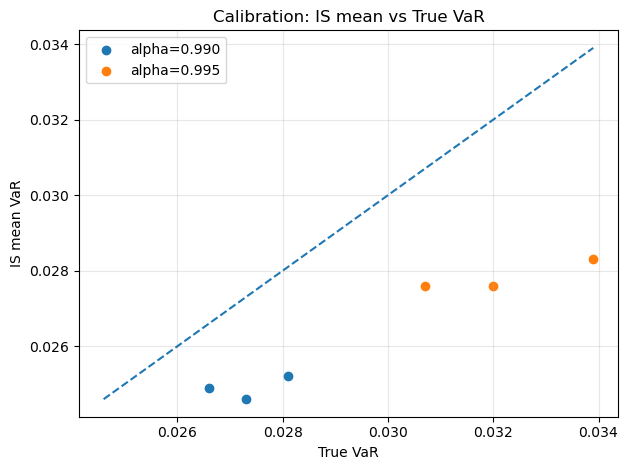

In [128]:
plt.figure()
for a in alphas:
    dfa = df[df["alpha"] == a]
    plt.scatter(dfa["trueVaR"], dfa["IS_mean"], label=f"alpha={a:.3f}")
mn = min(df["trueVaR"].min(), df["IS_mean"].min())
mx = max(df["trueVaR"].max(), df["IS_mean"].max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True VaR")
plt.ylabel("IS mean VaR")
plt.title("Calibration: IS mean vs True VaR")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


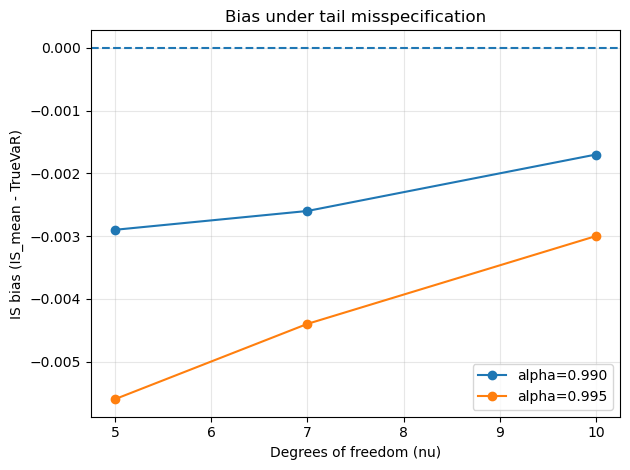

In [130]:
plt.figure()
for a in alphas:
    dfa = df[df["alpha"] == a].sort_values("nu")
    plt.plot(dfa["nu"], dfa["IS_bias"], marker="o", label=f"alpha={a:.3f}")
plt.axhline(0.0, linestyle="--")
plt.xlabel("Degrees of freedom (nu)")
plt.ylabel("IS bias (IS_mean - TrueVaR)")
plt.title("Bias under tail misspecification")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


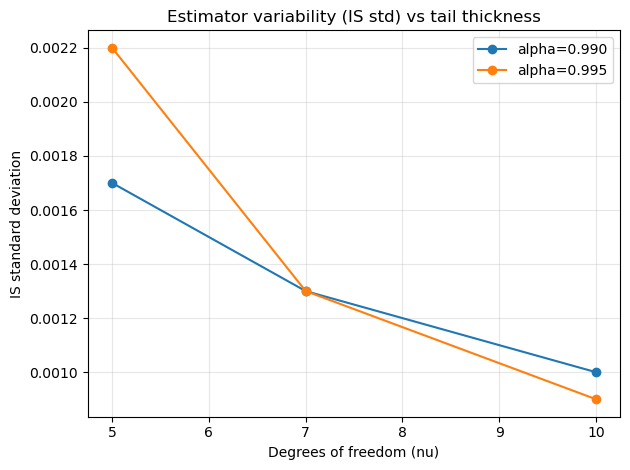

In [132]:
plt.figure()
for a in alphas:
    dfa = df[df["alpha"] == a].sort_values("nu")
    plt.plot(dfa["nu"], dfa["IS_std"], marker="o", label=f"alpha={a:.3f}")
plt.xlabel("Degrees of freedom (nu)")
plt.ylabel("IS standard deviation")
plt.title("Estimator variability (IS std) vs tail thickness")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


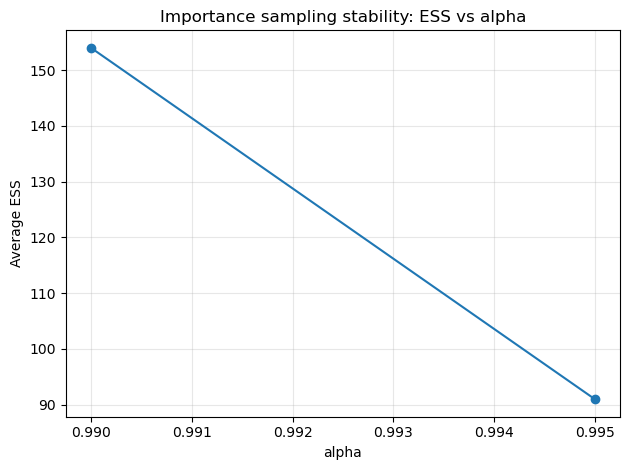

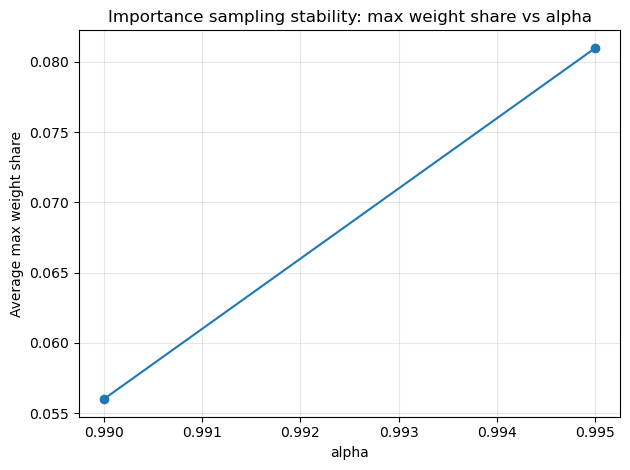

In [134]:
agg = df.groupby("alpha", as_index=False).agg(
    ESS_mean=("ESS", "mean"),
    maxW_mean=("maxW", "mean"),
)

plt.figure()
plt.plot(agg["alpha"], agg["ESS_mean"], marker="o")
plt.xlabel("alpha")
plt.ylabel("Average ESS")
plt.title("Importance sampling stability: ESS vs alpha")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(agg["alpha"], agg["maxW_mean"], marker="o")
plt.xlabel("alpha")
plt.ylabel("Average max weight share")
plt.title("Importance sampling stability: max weight share vs alpha")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


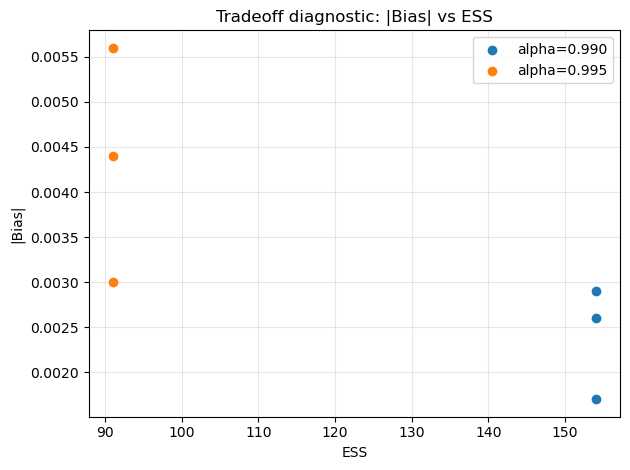

In [136]:
plt.figure()
for a in alphas:
    dfa = df[df["alpha"] == a]
    plt.scatter(dfa["ESS"], dfa["abs_bias"], label=f"alpha={a:.3f}")
plt.xlabel("ESS")
plt.ylabel("|Bias|")
plt.title("Tradeoff diagnostic: |Bias| vs ESS")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

